# Module 2 Project - Northwind Analysis / SQL 

- Student name: LaShanni Butler
- Student pace: part time
- Scheduled project review date/time: 3/22/19 at 2:15pm PST
- Instructor name: Jeff Herman

---

## Importing the libraries and databases

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

In [3]:
# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()


Comparing schema table vs. table names

In [4]:
inspector = inspect(engine)
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


<img src='Northwind_ERD.png'>

The number of schema names and table names show 13 tables total.

To analyze the SQL schema, I'll convert them into a Pandas dataframe

In [5]:
#convert sql tables into pandas dataframes
dfEmployee = pd.read_sql('SELECT * FROM [employee]', engine)
dfCategory = pd.read_sql('SELECT * FROM [category]', engine)
dfCustomer = pd.read_sql('SELECT * FROM [customer]', engine)
dfShipper = pd.read_sql('SELECT * FROM [shipper]', engine)
dfSupplier = pd.read_sql('SELECT * FROM [supplier]', engine)
dfOrder = pd.read_sql('SELECT * FROM [order]', engine)
dfProduct = pd.read_sql('SELECT * FROM [product]', engine)
dfOrderDetail = pd.read_sql('SELECT * FROM [orderdetail]', engine)
dfCustomerCustomerDemo = pd.read_sql('SELECT * FROM [customercustomerdemo]', engine)
dfCustomerDemographic = pd.read_sql('SELECT * FROM [customerdemographic]', engine)
dfRegion = pd.read_sql('SELECT * FROM [region]', engine)
dfTerritory = pd.read_sql('SELECT * FROM [territory]', engine)
dfEmployeeTerritory = pd.read_sql('SELECT * FROM [employeeterritory]', engine)


---

## Part 1: EDA - What is Northwind exactly?  

In [6]:
# A look at what prodcuts Northwind sells
dfCategory.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [7]:
dfCategory.tail()

,Id,CategoryName,Description
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


**Northwind appears to be a food distributor**

&nbsp;

In [8]:
# Checking out the regions Northwind covers
dfRegion.head()

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [9]:
dfTerritory.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [10]:
# I'd like to check their revenue sales for their products
cat_rev = pd.read_sql_query('''SELECT ca.CategoryName,
                                COUNT(DISTINCT p.ProductName) Products,
                                SUM((od.UnitPrice * (1 - od.Discount) * od.Quantity)) Revenue
                                FROM OrderDetail od
                                JOIN Product p ON od.ProductId = p.Id
                                JOIN Category ca ON p.CategoryId = ca.Id
                                GROUP BY ca.CategoryName
                                ORDER BY Revenue DESC
                            ''', engine)
cat_rev

,CategoryName,Products,Revenue
0,Beverages,12,267868.1800
1,Dairy Products,10,234507.2850
2,Confections,13,167357.2250
3,Meat/Poultry,6,163022.3595
4,Seafood,12,131261.7375
5,Condiments,12,106047.0850
6,Produce,5,99984.5800
7,Grains/Cereals,7,95744.5875


In [11]:
print(cat_rev['Products'].sum(), 'products sold.')

77 products sold.


**It seems Northwind sold 77 different types of products and Beverages and Dairy Products are the top sellers to their customer base.**

&nbsp;

In [12]:
# I wanted to see how many employees work at Northwind
dfEmployee.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [13]:
dfEmployee.tail()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


In [14]:
df = pd.read_sql_query('''SELECT e.Id, e.LastName, e.FirstName, e.Title, e.City Office, 
                            COUNT(DISTINCT od.OrderId) Orders_fulfilled,
                            SUM(od.Quantity) Unit_quantities_sold
                            FROM Employee e
                            JOIN [Order] o ON e.Id = o.EmployeeId
                            JOIN OrderDetail od ON o.Id = od.OrderId
                            JOIN EmployeeTerritory et ON et.EmployeeId = e.Id
                            JOIN Territory t on et.Territoryid = t.Id
                            JOIN Region r on t.RegionId = r.Id
                            GROUP BY e.Id
                            ORDER BY LastName
                        ''', engine)
df

,Id,LastName,FirstName,Title,Office,Orders_fulfilled,Unit_quantities_sold
0,5,Buchanan,Steven,Sales Manager,London,42,21252
1,8,Callahan,Laura,Inside Sales Coordinator,Seattle,104,23652
2,1,Davolio,Nancy,Sales Representative,Seattle,123,15624
3,9,Dodsworth,Anne,Sales Representative,London,43,18690
4,2,Fuller,Andrew,"Vice President, Sales",Tacoma,96,42385
5,7,King,Robert,Sales Representative,London,72,46540
6,3,Leverling,Janet,Sales Representative,Kirkland,127,31408
7,4,Peacock,Margaret,Sales Representative,Redmond,156,29394
8,6,Suyama,Michael,Sales Representative,London,67,17635


**There's a total of 9 Northwind employees.  Four employees are in London and the remaining are in the US.**

&nbsp;

In [15]:
# I now want to get a sense of the Northwind customers and which region they're located
dfCustomer.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [16]:
dfCustomer.tail()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
86,WARTH,Wartian Herkku,Pirkko Koskitalo,Accounting Manager,Torikatu 38,Oulu,Scandinavia,90110,Finland,981-443655,981-443655
87,WELLI,Wellington Importadora,Paula Parente,Sales Manager,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,(14) 555-8122,None
88,WHITC,White Clover Markets,Karl Jablonski,Owner,305 - 14th Ave. S. Suite 3B,Seattle,North America,98128,USA,(206) 555-4112,(206) 555-4115
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858
90,WOLZA,Wolski Zajazd,Zbyszek Piestrzeniewicz,Owner,ul. Filtrowa 68,Warszawa,Eastern Europe,01-012,Poland,(26) 642-7012,(26) 642-7012


**There are a total of 91 Northwind customers**

&nbsp;

In [17]:
customer_by_region = pd.read_sql_query('''SELECT c.Region
                                            FROM Customer c
                                        ''', engine)

customer_by_region['Region'].value_counts()

Western Europe     28
North America      16
South America      16
Southern Europe    10
British Isles       8
Central America     5
Northern Europe     4
Scandinavia         3
Eastern Europe      1
Name: Region, dtype: int64

**Overall, Northwind is a food distribution company with offices in London and the US.  They are a relatively small company comprising of 9 employees.  At quick glance, the London office appears to sell fewer products than the US.  Northwind has 91 customers and the regions customers are located are in the table above.  The top selling products are Beverages and Dairy Products.**

---

## Part 2: Hypothesis Testing

Questions:

1. Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

2. Question 2: Is there a statistically significant difference in USA vs. London employee performance?

3. Question 3:  Is there a statistical significance between discounts given by USA vs. London employees?

4. Question 4: Do USA or London employees have higher invoice totals?

> ### Hypothesis 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

* $H_0$: The average number of products ordered is the same regardless of their being a discount


* $H_\alpha$: The average number of products ordered with a discount is either higher or lower than orders without a discount




In [54]:
# Extracting the dataset for question 1 as a pandas dataframe
df1 = pd.read_sql_query('''SELECT Quantity, Discount FROM OrderDetail''', engine)
df1.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [19]:
df1.describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


In [20]:
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [21]:
# It might be best to drop discounts at 1%, 2%, 3%, 4% and 6% since they contribute very little to the dataset
df1 = df1[df1.Discount.isin(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25'])]

In [22]:
#dfOrderDetail.sort_values(by='Discount', ascending=False)
#create two data sets; one with the discount and one without
no_discount = dfOrderDetail[dfOrderDetail['Discount'] == 0.0]['Quantity'].values
discount = dfOrderDetail[dfOrderDetail['Discount'] != 0.0 ]['Quantity'].values

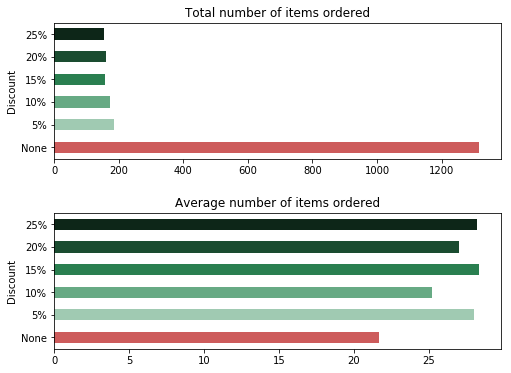

In [23]:
# Plotting the number of orders and average quantity of items ordered with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df1.groupby(['Discount'])['Quantity'].count().plot(kind='barh', ax=ax1, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
df1.groupby(['Discount'])['Quantity'].mean().plot(kind='barh', ax=ax2, colors=['indianred', '#A0CAB2', '#67AA84', '#2A7F50', '#1A4C30', '#0D2618'])
ax1.set_title('Total number of items ordered')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average number of items ordered')
ax1.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
ax2.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.4);

In [51]:
#find the mean and std for the two data sets
mu_no_discount = no_discount.mean()
mu_discount = discount.mean()
std_no_discount = no_discount.std()
std_discount = discount.std()

In [52]:
print('mu for no discount:', mu_no_discount)
print('mu for discount:', mu_discount)
print('\n')
print('std for no discount:', std_no_discount) 
print('std for discount:', std_discount)

mu for no discount: 21.715261958997722
mu for discount: 27.10978520286396


std for no discount: 17.500845477669806
std for discount: 20.759042075141373


In [53]:
stats.ttest_ind(no_discount, discount)

Ttest_indResult(statistic=-6.4785631962949015, pvalue=1.1440924523215966e-10)

___RESULT: The null hypothesis is rejected since the p value is 1.14 $e^{-10}$.   Having a discount or not does not affect price.___

&nbsp;

In [26]:
# Examing 5 discount datasets
discount5 = dfOrderDetail[dfOrderDetail['Discount'] == 0.05]['Quantity'].values
discount10 = dfOrderDetail[dfOrderDetail['Discount'] == 0.10]['Quantity'].values
discount15 = dfOrderDetail[dfOrderDetail['Discount'] == 0.15]['Quantity'].values
discount20 = dfOrderDetail[dfOrderDetail['Discount'] == 0.20]['Quantity'].values

In [27]:
print('mu for 5% discount: ', discount5.mean())
print('std for 5% discount: ', discount5.std())
print('mu for 10% discount: ', discount10.mean())
print('std for 10% discount: ', discount10.std())
print('mu for 15% discount: ', discount15.mean())
print('std for 15% discount: ', discount15.std())
print('mu for 20% discount: ', discount20.mean())
print('std for 20% discount: ', discount20.std())

mu for 5% discount:  28.01081081081081
std for 5% discount:  22.12763691763768
mu for 10% discount:  25.23699421965318
std for 10% discount:  21.125181975751996
mu for 15% discount:  28.38216560509554
std for 15% discount:  20.85635892029252
mu for 20% discount:  27.024844720496894
std for 20% discount:  18.774222551927533


In [28]:
print(stats.ttest_ind(no_discount, discount5))
print(stats.ttest_ind(no_discount, discount10))
print(stats.ttest_ind(no_discount, discount15))
print(stats.ttest_ind(no_discount, discount20))

Ttest_indResult(statistic=-4.418557901446638, pvalue=1.064949724167325e-05)
Ttest_indResult(statistic=-2.423258752228738, pvalue=0.015500606526440095)
Ttest_indResult(statistic=-4.411192556207304, pvalue=1.1027809944864872e-05)
Ttest_indResult(statistic=-3.6019486047561884, pvalue=0.00032631258591041463)


_**RESULT: Similarily, the p values for each category are less than the test statistic.  So I will reject the null hypothesis.**_

---

>### Hypothesis 2: Is there a statistically significant difference in USA vs. London employee performance?

$H_0$: There is no difference in performance between USA and London employees

$H_\alpha$: There is a difference in performance between USA and London employees

In [47]:
# Incorporating the database
employees_orders = pd.read_sql_query( '''
                                    
                                SELECT O.EmployeeId, E.Country, COUNT(O.Id) AS Total_Orders  
                                FROM [Order] AS O
                                JOIN Employee as E
                                ON O.EmployeeId = E.Id
                                GROUP BY O.EmployeeId
                                
                                ''' ,engine)
employees_orders

,EmployeeId,Country,Total_Orders
0,1,USA,123
1,2,USA,96
2,3,USA,127
3,4,USA,156
4,5,UK,42
5,6,UK,67
6,7,UK,72
7,8,USA,104
8,9,UK,43


In [30]:
#find the mean and std for the two data sets
usa = employees_orders[employees_orders.Country == 'USA']['Total_Orders']
london  = employees_orders[employees_orders.Country == 'UK']['Total_Orders']

In [31]:
mu_usa = usa.mean()
std_usa = usa.std()
mu_london = london.mean()
std_london = london.std()

In [49]:
print('mu for usa:', mu_usa)
print('std for usa:', std_usa)
print('\n')
print('mu for london:', mu_london)
print('std for london:', std_london)

mu for usa: 0.05282923755513548
std for usa: 0.0823848377442701


mu for london: 0.06549295774647888
std for london: 0.08574460634032187


In [33]:
stats.ttest_ind(usa, london)

Ttest_indResult(statistic=4.758164460817313, pvalue=0.002063854331616113)

_**RESULT: The p value is 0.002 which shows that I must reject the null hypothesis Result of the test shows that there is a statistically significant difference in employee performance between the 2 office.**_

---

>### Hypothesis 3:  Is there a statistical significance between discounts given by USA vs. London employees?

$H_0$: There is no difference in discounts given by from USA and London employees

$H_\alpha$: There is a difference in discounts given by from USA and London employees

In [34]:
# Incorporating the database
us_london_discount = pd.read_sql_query('''

                    SELECT OD.Discount, E.Country FROM [Order] AS O
                    JOIN OrderDetail AS OD ON O.Id = OD.OrderId
                    JOIN Employee AS E ON O.EmployeeId = E.Id

                    ''', engine)
us_london_discount

,Discount,Country
0,0.00,UK
1,0.00,UK
2,0.00,UK
3,0.00,UK
4,0.00,UK
5,0.00,USA
6,0.15,USA
7,0.15,USA
8,0.05,USA
9,0.05,USA


In [35]:
#find the mean and std for the two data sets
usa = us_london_discount[us_london_discount.Country == 'USA']['Discount']
london  = us_london_discount[us_london_discount.Country == 'UK']['Discount']

In [36]:
mu_usa = usa.mean()
std_usa = usa.std()
mu_london = london.mean()
std_london = london.std()

In [48]:
print('mu for usa:', mu_usa)
print('std for usa:', std_usa)
print('\n')
print('mu for london:', mu_london)
print('std for london:', std_london)

mu for usa: 0.05282923755513548
std for usa: 0.0823848377442701


mu for london: 0.06549295774647888
std for london: 0.08574460634032187


In [38]:
stats.ttest_ind(usa, london)

Ttest_indResult(statistic=-3.109889948576017, pvalue=0.0018960759380324476)

_**RESULT: There is statistically significant difference in discount amount between employees from USA and London.  This result shows we must reject null hypothesis.**_

---

>### Hypothesis 4: Do USA or London employees have higher invoice totals?

$H_0$: London invoice totals are higher than USA invoices totals

$H_\alpha$: London invoice totals are lower than USA invoice totals

In [39]:
#A way of measuring "effect" relative to the parameters of the
#control and treatment groups.
# 0.2 may be considered a "small" effect; 0.5 "medium"; 0.8 "large"
def cohend(control, treatment):
    numer = control.mean() - treatment.mean()
    var = ((len(control) * control.var()) + (len(treatment) * treatment.var())) / len(control) + len(treatment)
    denom = np.sqrt(var)
    return numer / denom

In [40]:
#Get invoice totals for employees in the USA offices
usa_invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City != "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

In [41]:
#Get invoice totals for employees in the London office
london_invoices = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                            WHERE e.City = "London"
                            GROUP BY od.OrderId
                            ORDER BY e.LastName
                    ''', engine)

In [42]:
usa_invoices.head()

,OrderId,Invoice_total
0,10262,584.0
1,10268,1101.2
2,10276,420.0
3,10278,1488.8
4,10279,351.0


In [43]:
#Taking a look at the data
london_invoices.head()

,OrderId,Invoice_total
0,10248,440.00
1,10254,556.62
2,10269,642.20
3,10297,1420.00
4,10320,516.00


In [44]:
#Value to compare to p-value
alpha = 0.05

#A control group from the London invoices
#A treatment group from the USA invoices
control2 = london_invoices['Invoice_total']
treatment2 = usa_invoices['Invoice_total']

In [45]:
print('USA invoice mu:', treatment2.mean())
print('Number of USA invoices:', len(treatment2))
print('\n')
print('London invoice mu:', control2.mean())
print('Number of London invoices:', len(control2))

USA invoice mu: 1520.150702970297
Number of USA invoices: 606


London invoice mu: 1538.3112209821427
Number of London invoices: 224


In [46]:
t2, p2 = stats.ttest_ind(control2,treatment2, equal_var = False)
print('T stat is', t2)
print('P-value is', p2)
if p2 > alpha:
    print('Cohen\'s D is', cohend(control2, treatment2))

T stat is 0.12383782386231988
P-value is 0.9015080381474158
Cohen's D is 0.005109731621820012


_**RESULT: The p value is 0.90, which is greater than 0.05, so we must fail to reject the null hypothesis.**_

---

### Conclusions:

- Hypothesis 1: There is a significant increase in quantity of products ordered when a discount is applied or not

- Hypothesis 2: There is statistically significant difference in orders quantity between two groups of employees from USA and London

- Hypothesis 3: Results shows there is statistically significant difference in discount amount between employees from USA and London

- Hypothesis 4: Invoice totals from the London office are just about average (or higher) when compared to the USA offices.
